# Read MYD35_L2, MYD06_L2 and LID_L2_05km_MLay products and identify the relevant properties

## Read MYD06 file and plot cloud phase

109620


/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


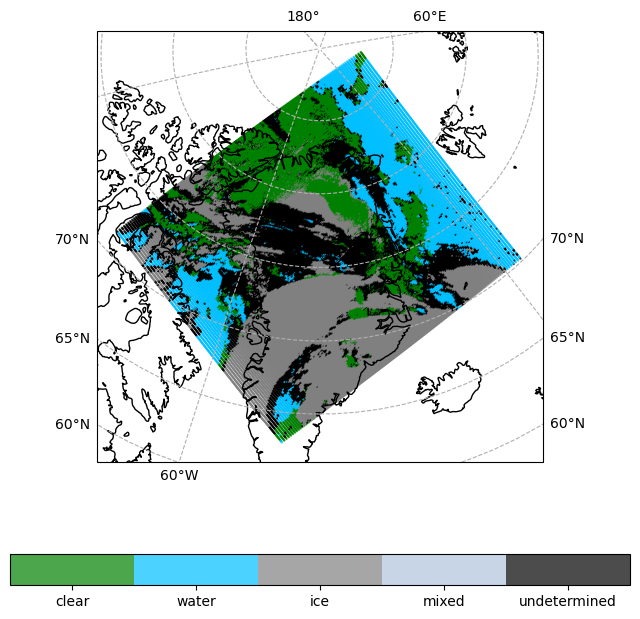

In [176]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()

modis_cloud_phase_day = MODIS_reader.select("Cloud_Phase_Infrared_Day").get()
modis_cloud_phase_night = MODIS_reader.select("Cloud_Phase_Infrared_Day").get()
invalid_data_mask_day = modis_cloud_phase_day > 6
invalid_data_mask_night = modis_cloud_phase_night > 6

modis_cloud_phase_day = np.ma.array(modis_cloud_phase_day, mask=invalid_data_mask_day)
modis_cloud_phase_night = np.ma.array(modis_cloud_phase_night, mask=invalid_data_mask_night)

invalid_data_mask = modis_cloud_phase > 6
modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_phase = np.ma.array(modis_cloud_phase, mask=invalid_data_mask)

print(np.size(modis_cloud_phase))


def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=2, cmap=colormap, transform=ccrs.PlateCarree(), alpha=0.7)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))

cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])


## Read MYD06 data and plot cloud fractions

array([[<Axes: title={'center': 'frac'}>]], dtype=object)

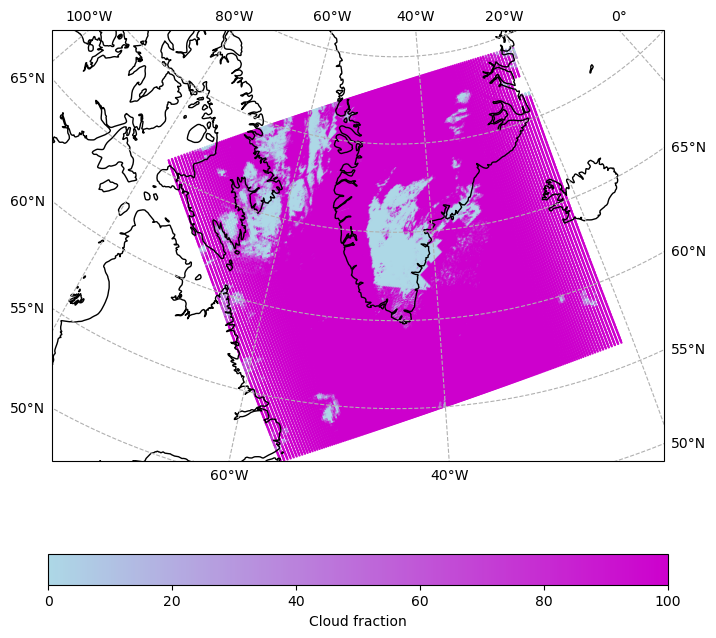

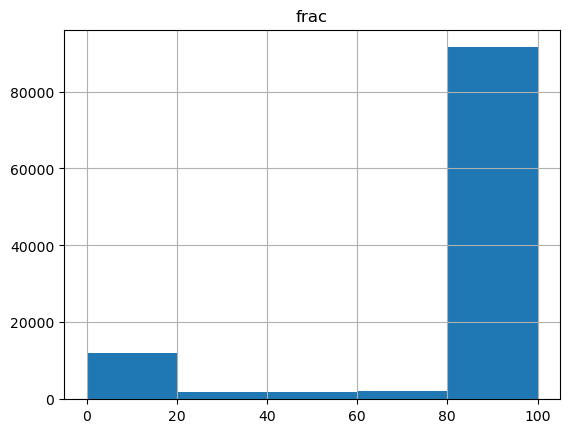

In [133]:
modis_cloud_fraction = MODIS_reader.select("Cloud_Fraction").get()
invalid_data_mask = modis_cloud_fraction > 100

modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_fraction = np.ma.array(modis_cloud_fraction, mask=invalid_data_mask)


def create_skyblue_to_transparent_cmap():
    # Define the colors
    colors = [(173/255, 216/255, 230/255, 1), (205/255, 0/255, 205/255, 1)]

    # Create the colormap
    cmap = LinearSegmentedColormap.from_list("lightblue_to_grey", colors)

    return cmap

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=modis_cloud_fraction, marker='.', s=2, transform=ccrs.PlateCarree(),
                 cmap=create_skyblue_to_transparent_cmap())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", label="Cloud fraction")

import pandas as pd
df = pd.DataFrame(np.array(modis_cloud_fraction).flatten(), columns=["frac"])
df = df[df.frac < 101]
df.hist(bins=5)


## Read MYD06 data and plot cloud mask

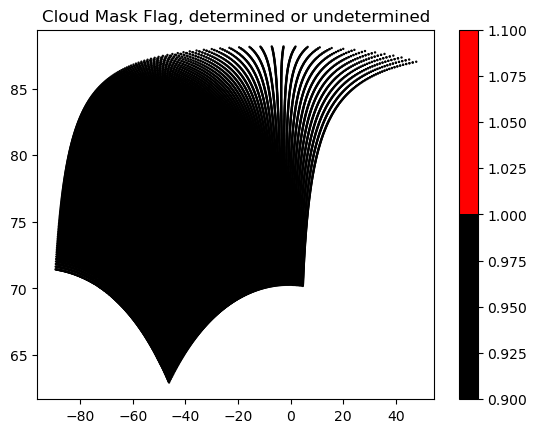

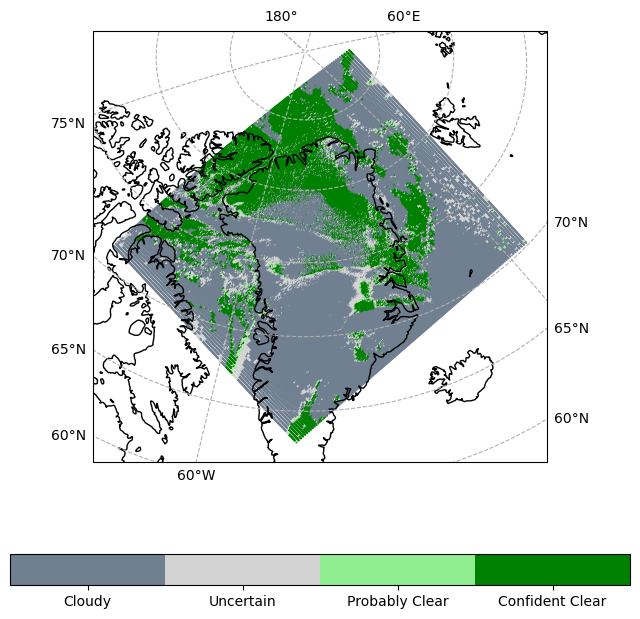

In [174]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_mask_5km = MODIS_reader.select("Cloud_Mask_5km").get()[:,:,0]

# the following section is almost entirely written using ChatGPT

def vectorized_parse_byte_properties(byte_array):
    # Vectorized version of parse_byte_properties function
    properties = {}

    # Bit 0: Cloud Mask Flag
    properties['Cloud Mask Flag'] = np.where((byte_array & 0b1) == 0, 'Not determined', 'Determined')

    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 'Cloudy',
        0b01: 'Uncertain',
        0b10: 'Probably Clear',
        0b11: 'Confident Clear'
    }
    properties['Unobstructed FOV Quality Flag'] = np.vectorize(quality_mapping.get)(quality_flag)

    # Bit 3: Day or Night Path
    properties['Day or Night Path'] = np.where((byte_array >> 2) & 0b1 == 0, 'Night', 'Day')

    # Bit 4: Sunglint Path
    properties['Sunglint Path'] = np.where((byte_array >> 3) & 0b1 == 0, 'Yes', 'No')

    # Bit 5: Snow/Ice Background Path
    properties['Snow/Ice Background Path'] = np.where((byte_array >> 4) & 0b1 == 0, 'Yes', 'No')

    # Bits 7-6: Land or Water Path
    land_water_flag = (byte_array >> 5) & 0b11
    land_water_mapping = {
        0b00: 'Water',
        0b01: 'Coastal',
        0b10: 'Desert',
        0b11: 'Land'
    }
    properties['Land or Water Path'] = np.vectorize(land_water_mapping.get)(land_water_flag)

    return properties

# Example usage with a NumPy array of bytes
byte_array = np.array(modis_cloud_mask_5km, dtype=np.uint8).flatten()
result = vectorized_parse_byte_properties(byte_array)

# Map colors to property values
color_mapping = {
    'Cloudy': 0,
    'Uncertain': 1,
    'Probably Clear': 2,
    'Confident Clear': 4
}

# Extract Unobstructed FOV Quality Flag data
quality_flag_data = result['Unobstructed FOV Quality Flag']
color_matrix = np.vectorize(color_mapping.get)(quality_flag_data)
colormap = ListedColormap(['slategrey', 'lightgrey', 'lightgreen', 'green'])

# check if there are undetermined cloud mask pixels
plt.scatter(modis_long, modis_lat, marker='.', s=2, c=np.where(result["Cloud Mask Flag"] == "Determined", 1, 0), cmap=ListedColormap(["black", "red"]))
plt.colorbar()
plt.gca().set_title("Cloud Mask Flag, determined or undetermined")

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
# ccrs_projection = ccrs.NorthPolarStereo()
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent((np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)), ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
pos = ax.scatter(modis_long, modis_lat, c=color_matrix, marker='.', s=2, transform=ccrs.PlateCarree(), cmap=colormap)
cbar = fig.colorbar(pos, ticks=[0.5, 1.5, 2.5, 3.5], location="bottom")
cbar.set_ticklabels(['Cloudy', 'Uncertain', 'Probably Clear', 'Confident Clear'])

# Use collocation database to load CALIOP and MODIS products

## Select date and load collocation csv

In [2]:
import pandas as pd
import os
import datetime

path_to_collocation_database = "./collocation_database/"
selected_date = datetime.datetime(year=2017, month=1, day=1)

def select_CALIOP_file_by_day(path_to_month_folder, day):
    import glob

    search_pattern = f"*-{day:02d}T*"
    return glob.glob(search_pattern, root_dir=path_to_month_folder)

path_to_collocation_month = os.path.join(path_to_collocation_database, selected_date.strftime("%Y/%m"))

selected_CALIOP_file_list = select_CALIOP_file_by_day(path_to_collocation_month, selected_date.day)

collocated_dfs = {}

for file in selected_CALIOP_file_list:
    collocated_dfs[file[0:-4]] = pd.read_csv(os.path.join(path_to_collocation_month, file))
    display(collocated_dfs[file[0:-4]].MODIS_file.describe())

count                                              257
unique                                               1
top       MYD35_L2.A2017001.1350.061.2018029021044.hdf
freq                                               257
Name: MODIS_file, dtype: object

count                                              130
unique                                               2
top       MYD35_L2.A2017001.1530.061.2018029020435.hdf
freq                                               124
Name: MODIS_file, dtype: object

count                                              250
unique                                               1
top       MYD35_L2.A2017001.1525.061.2018029020525.hdf
freq                                               250
Name: MODIS_file, dtype: object

count                                              257
unique                                               1
top       MYD35_L2.A2017001.1350.061.2018029021044.hdf
freq                                               257
Name: MODIS_file, dtype: object

## Understand CALIOP layer data

./test_data/CALIOP/2017/01/CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN.hdf
(15, 3728)


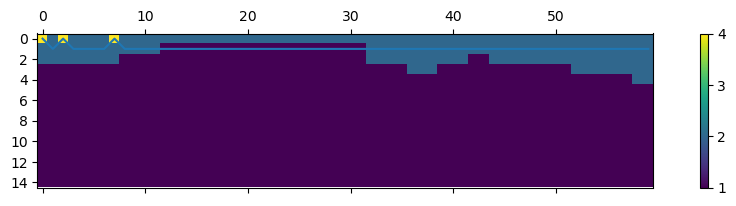

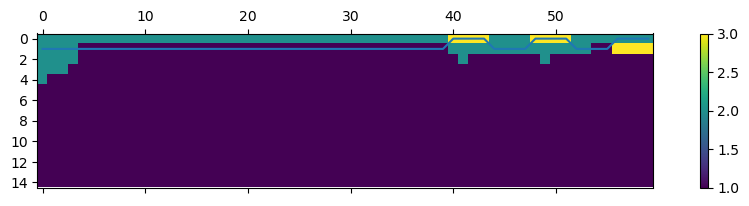

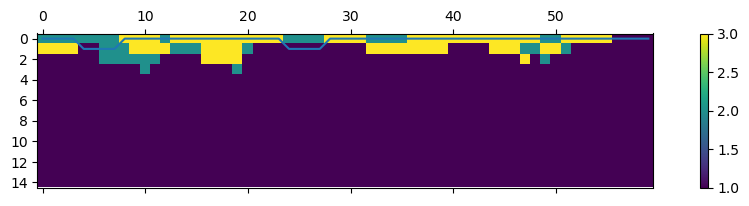

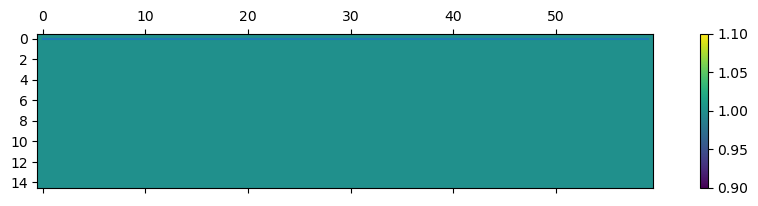

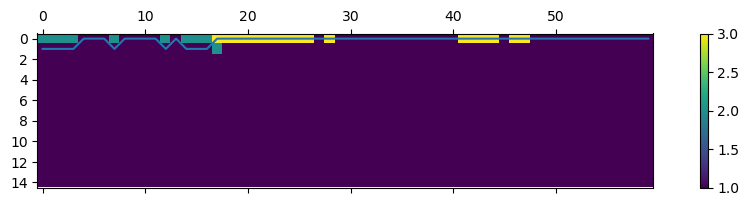

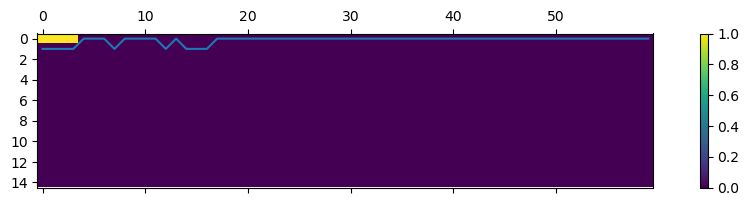

In [80]:
from caliop import Caliop_hdf_reader
import numpy as np
import matplotlib.pyplot as plt

caliop_folder = "./test_data/CALIOP/"
caliop_folder = os.path.join(caliop_folder, selected_date.strftime("%Y/%m"), )

caliop_reader = Caliop_hdf_reader()
# for file in selected_CALIOP_file_list:
filepath = os.path.join(caliop_folder, selected_CALIOP_file_list[3][0:-4] + ".hdf")
print(filepath)

caliop_long, caliop_lat = caliop_reader._get_longitude(filepath), caliop_reader._get_latitude(filepath)

# the first output variable is aerosol type, which I do not need
# feature_classification = caliop_reader._get_calipso_data(filepath, "Layer_Type")
_, feature_classification = caliop_reader._get_feature_classification(filepath, "Feature_Classification_Flags")
cloud_phase, cloud_phase_qa = caliop_reader._get_cloud_phase(filepath, "Feature_Classification_Flags")

print(np.shape(cloud_phase))

cloudy_aerosol_free_profiles_mask = np.where(np.any(feature_classification == 2, axis=0) &\
                                          ~np.any(feature_classification == 3, axis=0) &\
                                            ~np.any(feature_classification == 4, axis=0), True, False)

for i in range(5):
    fig, ax = plt.subplots(figsize=(12,2))
    pos = ax.matshow(feature_classification[:, 60 * i:60 + 60 * i])
    ax.plot(cloudy_aerosol_free_profiles_mask[60 * i:60 + 60 * i])
    fig.colorbar(pos)

# i=13
# plt.matshow(feature_classification[:, 60 * i:60 + 60 * i])
# plt.colorbar()
fig, ax = plt.subplots(figsize=(12,2))
pos = ax.matshow(cloud_phase[:, 60 * i:60 + 60 * i])
ax.plot(cloudy_aerosol_free_profiles_mask[60 * i:60 + 60 * i])
fig.colorbar(pos)

## Build CALIOP layer data DataFrame

In [154]:
import pandas as pd
import os
from caliop import Caliop_hdf_reader
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap

path_to_collocation_database = "./collocation_database/"
path_to_CALIOP_data = "./test_data/CALIOP/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN"

collocation_filepath = os.path.join(path_to_collocation_database, date_folder, caliop_filename + ".csv")
caliop_data_filepath = os.path.join(path_to_CALIOP_data, date_folder, caliop_filename + ".hdf")

collocation_table = pd.read_csv(collocation_filepath)

def CALIOP_cloud_phase_to_DataFrame(caliop_data_filepath):
    reader_caliop = Caliop_hdf_reader()
    caliop_df = pd.DataFrame(columns=["long", "lat", "time", "profile_id"])
    caliop_df.long = reader_caliop._get_longitude(caliop_data_filepath)
    caliop_df.lat = reader_caliop._get_latitude(caliop_data_filepath)
    caliop_df.time = reader_caliop._get_profile_UTC(caliop_data_filepath)
    caliop_df.profile_id = reader_caliop._get_profile_id(caliop_data_filepath)
    caliop_df = caliop_df.set_index('profile_id')
    _, layer_type = reader_caliop._get_feature_classification(caliop_data_filepath, "Feature_Classification_Flags")
    caliop_df["cloudy"] = np.where(np.any(layer_type == 2, axis=0), True, False)
    # caliop_df["aerosol_free_cloud"] = np.where((~np.any(layer_type == 3, axis=0) &\
    #                                     ~np.any(layer_type == 4, axis=0)) &\
    #                                         np.any(layer_type == 2, axis=0), True, False)
    caliop_df["clear"] = np.where(np.all(layer_type == 1, axis=0), True, False)
    caliop_df["invalid"] = np.where(np.any(layer_type == 0, axis=0), True, False)
    caliop_df["aerosol"] = np.where((np.any(layer_type == 3, axis=0) |\
                                        np.any(layer_type == 4, axis=0)), True, False)
    # caliop_df["cloud_free_aerosol"] = np.where((np.any(layer_type == 3, axis=0) |\
    #                                     np.any(layer_type == 4, axis=0)) &\
    #                                         ~np.any(layer_type == 2, axis=0), True, False)

    cloud_phase_layer, cloud_phase_layer_qa = reader_caliop._get_cloud_phase(caliop_data_filepath, "Feature_Classification_Flags")

    caliop_df["water_cloud"] = np.where(np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)
    caliop_df["ice_cloud"] = np.where((np.any(cloud_phase_layer == 1, axis=0) |\
                                        np.any(cloud_phase_layer == 3, axis=0)) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0), True, False)
    caliop_df["mixed_phase"] = np.where((np.any(cloud_phase_layer == 1, axis=0) |\
                                        np.any(cloud_phase_layer == 3, axis=0)) &\
                                        np.any(cloud_phase_layer == 2, axis=0), True, False)
    caliop_df["unkown_phase"] = np.where(caliop_df["cloudy"] &\
                                        np.any(cloud_phase_layer == 0, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)

    return caliop_df

caliop_df = CALIOP_cloud_phase_to_DataFrame(caliop_data_filepath).loc[collocation_table.profile_id]

display(caliop_df.head())
print("total profiles ", len(caliop_df))
print("all clear ", sum(caliop_df.clear))
print("all invalid ", sum(caliop_df.invalid))
print("aerosol profiles ", sum(caliop_df.aerosol))
# print("cloud free aerosol profiles ", sum(caliop_df.cloud_free_aerosol))
# print("aerosol free cloud profiles ", sum(caliop_df.aerosol_free_cloud))
print("cloudy profiles ", sum(caliop_df.cloudy))
print("of which water clouds", sum(caliop_df.water_cloud))
print("or ice clouds ", sum(caliop_df.ice_cloud))
print("or mixed phase ", sum(caliop_df.mixed_phase))
print("cloudy, unknown phase ", sum(caliop_df.unkown_phase))

,long,lat,time,cloudy,clear,invalid,aerosol,water_cloud,ice_cloud,mixed_phase,unkown_phase
profile_id,,,,,,,,,,,
27210,-28.642246,72.176956,2017-01-01 13:52:35,True,False,False,True,False,True,False,False
27225,-28.713709,72.216904,2017-01-01 13:52:35,True,False,False,False,False,True,False,False
27240,-28.785179,72.256775,2017-01-01 13:52:36,True,False,False,True,False,True,False,False
27255,-28.858015,72.296562,2017-01-01 13:52:37,True,False,False,False,False,True,False,False
27270,-28.930428,72.336159,2017-01-01 13:52:38,True,False,False,False,False,True,False,False


total profiles  257
all clear  72
all invalid  0
aerosol profiles  63
cloudy profiles  160
of which water clouds 38
or ice clouds  89
or mixed phase  15
cloudy, unknown phase  18


## Compare to MODIS cloud-phase classification

/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


160


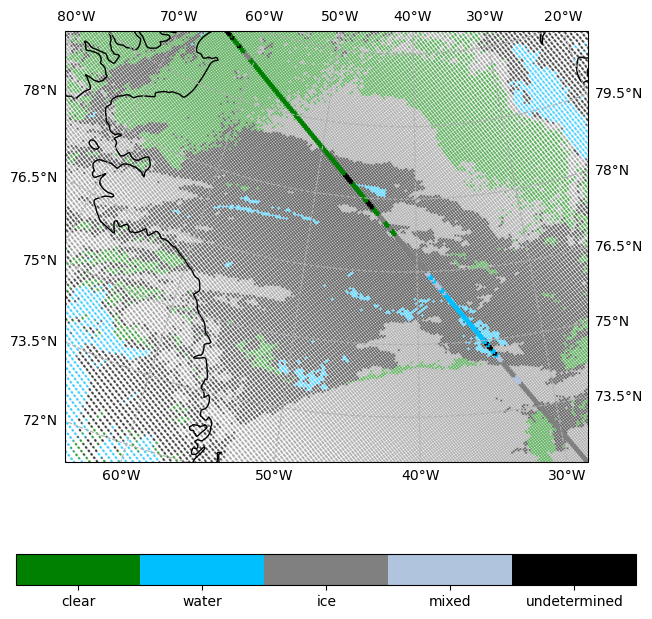

In [155]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()

invalid_data_mask = modis_cloud_phase > 6
modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_phase = np.ma.array(modis_cloud_phase, mask=invalid_data_mask)

def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])
color_array = np.where(caliop_df.water_cloud, 1, 0) + np.where(caliop_df.unkown_phase, 5, 0) +\
                np.where(caliop_df.ice_cloud, 2, 0) + np.where(caliop_df.mixed_phase, 3, 0) + 0.5

print(sum(caliop_df.water_cloud | caliop_df.ice_cloud | caliop_df.mixed_phase | caliop_df.unkown_phase))

ccrs_projection = ccrs.Orthographic(central_longitude=caliop_df.long.median(), central_latitude=caliop_df.lat.median())
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent([caliop_df.long.min(), caliop_df.long.max(), caliop_df.lat.min(), caliop_df.lat.max()])
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=2, cmap=colormap, transform=ccrs.PlateCarree(), alpha=0.5)
pos = ax.scatter(caliop_df.long, caliop_df.lat, marker='*', s=10, c=color_array, cmap=colormap, transform=ccrs.PlateCarree(), alpha=1)
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))
# cbar = fig.colorbar(pos, ax=ax, location="bottom")
cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])

fig.savefig("temp.png", dpi=500)

## Only plot collocated MODIS pixels and their phase

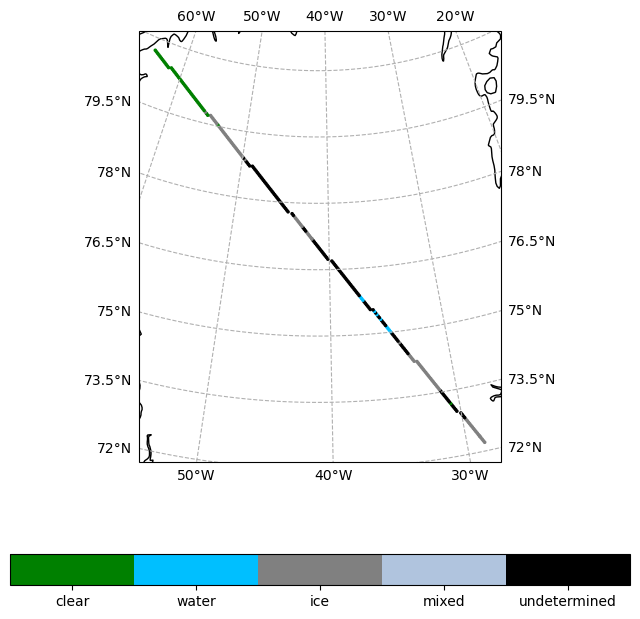

In [6]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

path_to_collocation_database = "./collocation_database/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN"

collocation_filepath = os.path.join(path_to_collocation_database, date_folder, caliop_filename + ".csv")
collocation_table = pd.read_csv(collocation_filepath)

MODIS_filename = "MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_filename = "MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_filename = "MYD06_L2.A2017001.1530.061.2018029075939.hdf"
# filename_mask = collocation_table.MODIS_file == MODIS_filename
modis_collocated_indices = collocation_table.modis_idx

MODIS_path = os.path.join("./test_data/MODIS/2017/01/01/", MODIS_filename)

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()


modis_long = np.array(modis_long).flatten()[modis_collocated_indices]
modis_lat = np.array(modis_lat).flatten()[modis_collocated_indices]
modis_cloud_phase = np.array(modis_cloud_phase).flatten()[modis_collocated_indices]

modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=10, cmap=colormap, transform=ccrs.PlateCarree(), alpha=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))

cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])

# Compile statistics

## What is the Viewing Angle distribution?

### Sensor Zenith Angle is the variable I care about. Read it and plot it

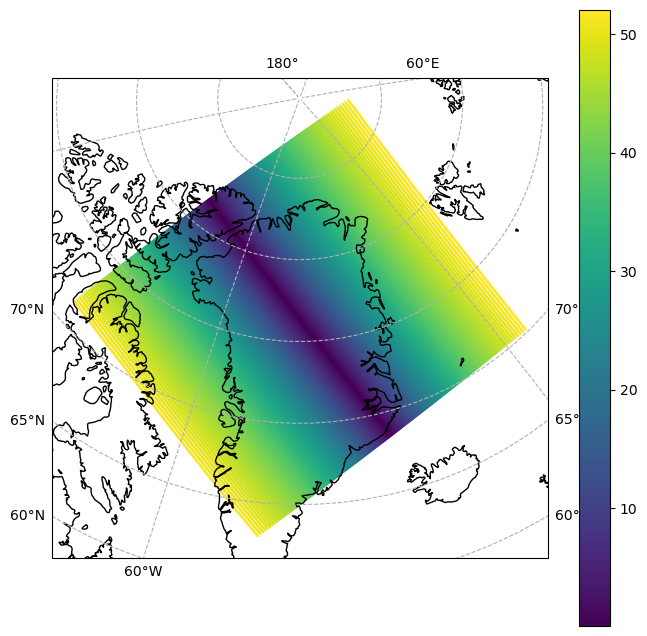

In [6]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
sensor_zenith_angle = MODIS_reader.select("Sensor_Zenith").get() / 3600 * 180/np.pi/2

modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=sensor_zenith_angle, marker='.', s=2, transform=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
fig.colorbar(pos)

### Read the collocation database for January of 2017

0it [00:00, ?it/s]

3it [00:00, 69.90it/s]

637


(array([43., 92., 60., 90., 92., 42., 63., 38., 65., 52.]),
 array([1.10612685, 1.6806762 , 2.25522554, 2.82977489, 3.40432423,
        3.97887358, 4.55342292, 5.12797227, 5.70252161, 6.27707096,
        6.8516203 ]),
 <BarContainer object of 10 artists>)

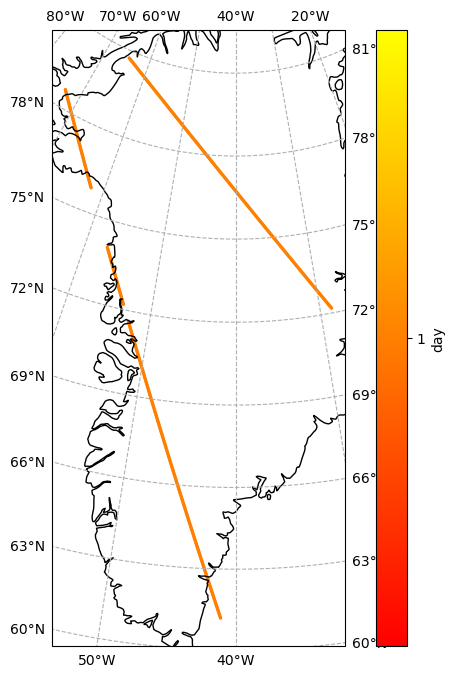

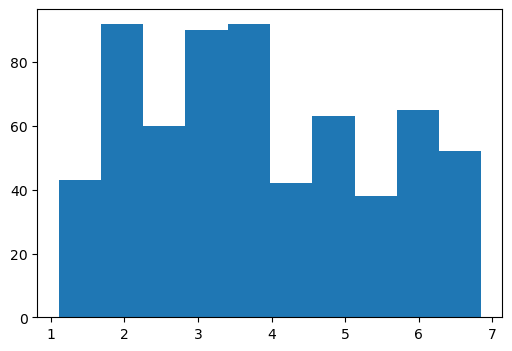

In [23]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import os
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import datetime
import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

path_to_2017_collocation_database = \
    "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/collocation_database/2017/01"
path_to_MODIS_folder = "./test_data/MODIS/2017/01/01/"

def get_sensor_zenith_angle(folder, collocation):
    modis_files = collocation.MODIS_file.unique()
    readers = {}
    search_strings = {}
    pixel_angles = np.zeros(len(collocation.index))
    file_found = True

    for modis_file in modis_files:
        search_strings[modis_file] = modis_file[9:22]
        myd06_file = ""
        for filename in os.listdir(folder):
            if search_strings[modis_file] in filename:
                myd06_file = os.path.basename(filename)
                file_found = True
                break
            else:
                file_found = False
            
        if not file_found:
            continue

        readers[modis_file] = SD(os.path.join(folder, myd06_file))
        pixel_angles += np.where(collocation.MODIS_file == modis_file,\
                            np.array(readers[modis_file].select("Sensor_Zenith").get()).flatten()[collocation.modis_idx], 0)
        
    return pixel_angles


collocation_csv_filelist = os.listdir(path_to_2017_collocation_database)

total_collocated_pixels = 0

ccrs_projection = ccrs.Orthographic(central_longitude=-40, central_latitude=75)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")

longs, lats = np.empty((1,)), np.empty((1,))
days = np.empty((1,))
pixel_angles = np.zeros((1,))

for file_index, file in tqdm.tqdm(enumerate(collocation_csv_filelist)):
    collocation = pd.read_csv(os.path.join(path_to_2017_collocation_database, file))
    total_collocated_pixels += len(collocation.index)

    pixel_angles = np.concatenate([pixel_angles, (get_sensor_zenith_angle(path_to_MODIS_folder, collocation))])

    days = np.concatenate((days,[date.day for date in pd.to_datetime(collocation.time)]))
    longs = np.concatenate((longs, collocation.long))
    lats = np.concatenate((lats, collocation.lat))

pos = ax.scatter(longs[1:], lats[1:], c=days[1:], s=2, transform=ccrs.PlateCarree(), cmap="autumn")
fig.colorbar(pos, label="day", ticks=range(1, 32, 5))

print(total_collocated_pixels)

pixel_angles = pixel_angles[1:] / 3600 * 90 / np.pi
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(pixel_angles)